# Initial protype of the Euler inversion code

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd

## Make synthetic data

In [2]:
random = np.random.RandomState(0)

In [55]:
region = [50e3, 150e3, 100e3, 250e3]
height = 500
#coordinates = vd.scatter_points(region, size=1000, random_state=0, extra_coords=height)
coordinates = [i.ravel() for i in vd.grid_coordinates(region, shape=(40, 40), extra_coords=height)]
x, y, z = coordinates
center = [110e3, 130e3, -5e3]
mass = 200 * 4 / 3 * np.pi * np.abs(center[2]) ** 3
base_level = 3
gravity = hm.point_mass_gravity(coordinates, center, mass, field="g_z") + base_level
delta = 1
xderiv = (
    hm.point_mass_gravity((x + delta, y, z), center, mass, field="g_z")
    - hm.point_mass_gravity((x - delta, y, z), center, mass, field="g_z")
) / 2 * delta
yderiv = (
    hm.point_mass_gravity((x, y + delta, z), center, mass, field="g_z")
    - hm.point_mass_gravity((x, y - delta, z), center, mass, field="g_z")
) / 2 * delta
zderiv = (
    hm.point_mass_gravity((x, y, z + delta), center, mass, field="g_z")
    - hm.point_mass_gravity((x, y, z - delta), center, mass, field="g_z")
) / 2 * delta


gravity += random.normal(loc=0, scale=0.2, size=gravity.size)
xderiv += random.normal(loc=0, scale=0.00005, size=xderiv.size)
yderiv += random.normal(loc=0, scale=0.00005, size=xderiv.size)
zderiv += random.normal(loc=0, scale=0.00005, size=xderiv.size)

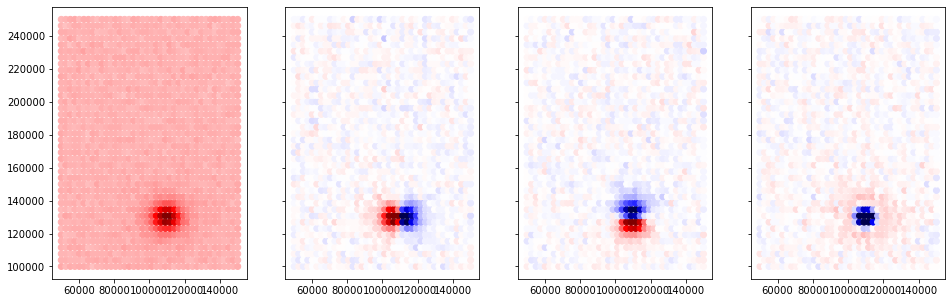

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

scale = 0.002
cmap = "seismic"

ax = axes[0]
ax.scatter(x, y, c=gravity, cmap=cmap, vmin=-20, vmax=20)

for ax, data in zip(axes[1:], [xderiv, yderiv, zderiv]):
    ax.scatter(x, y, c=data, cmap=cmap, vmin=-scale, vmax=scale)

## Calculate the matrices involved

In [57]:
def jacobian_parameters(xderiv, yderiv, zderiv, structural_index):
    """
    Calculate the model parameter Jacobian.
    """
    jacobian = np.empty((xderiv.size, 4))
    jacobian[:, 0] = -xderiv
    jacobian[:, 1] = -yderiv
    jacobian[:, 2] = -zderiv
    jacobian[:, 3] = -structural_index
    return jacobian

In [58]:
def jacobian_data(x, y, z, xo, yo, zo, structural_index):
    """
    Calculate the data Jacobian.
    """
    nequations = x.size
    ndata = nequations * 4
    diagonal = np.arange(nequations)
    jacobian = sparse.hstack(
        [
            sparse.diags(np.full(nequations, structural_index)),
            sparse.diags(x - xo),
            sparse.diags(y - yo),
            sparse.diags(z - zo),
        ],
        format="csc",
    )
    return jacobian

In [59]:
def eulers_equation(x, y, z, data, parameters, structural_index):
    """
    Evaluate Euler's equation.
    """
    nequations = x.size
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, baselevel = parameters
    euler = (
        (x - xo) * dx + (y - yo) * dy + (z - zo) * dz + structural_index * (h - baselevel)
    )
    return euler

In [60]:
def gauss_newton_step(parameters, data, coordinates, data_observed, Wd_inv, Wp, structural_index):
    """
    Take a step in Gauss-Newton and return new parameters and data.
    """
    x, y, z = coordinates
    h, dx, dy, dz = np.split(data, 4)
    xo, yo, zo, base_level = parameters
    A = jacobian_parameters(dx, dy, dz, structural_index)
    B = jacobian_data(x, y, z, xo, yo, zo, structural_index)    
    r = data_observed - data
    f = eulers_equation(x, y, z, data, parameters, structural_index)
    Q = B @ Wd_inv @ B.T
    Q_inv = sparse.linalg.inv(Q)
    ATQ = A.T @ Q_inv
    BTQ = B.T @ Q_inv
    Br = B @ r
    Wd_invBTQ = Wd_inv @ BTQ
    deltap = np.linalg.solve(
        ATQ @ A + Wp,
        -ATQ @ (f + Br)
    )
    deltad = r - Wd_invBTQ @ Br - Wd_invBTQ @ (f + A @ deltap)
    return deltap, deltad

In [78]:
def euler_inversion(coordinates, field, xderiv, yderiv, zderiv, structural_index, step=10, step_change=2, maxit=100, tol=1e-5):
    """
    """
    region = vd.get_region(coordinates)
    area = (region[1] - region[0]) * (region[3] - region[2])
    data_observed = np.concatenate([field, xderiv, yderiv, zderiv])
    
    parameters = np.array([
        0.5 * (region[1] + region[0]),
        0.5 * (region[3] + region[2]),
        -np.mean(coordinates[2]),
        0,
    ])
    data = np.zeros_like(data_observed)
    data = 0.1 * np.copy(data_observed)
    
    derivative_norm = np.mean([
        np.linalg.norm(xderiv),
        np.linalg.norm(yderiv),
        np.linalg.norm(zderiv),        
    ])
    
    wd = np.concatenate([
        np.full_like(field, 1 / np.linalg.norm(field) ** 2),
        np.full_like(field, 1 / derivative_norm**2),
        np.full_like(field, 1 / derivative_norm ** 2),
        np.full_like(field, 1 / derivative_norm ** 2),
    ])
    #wd = np.ones_like(data)
    
    wp = np.array([
        1 / area,
        1 / area,
        1 / area,
        1 / np.linalg.norm(field) ** 2,
    ])
    wp = np.where(wp > 1e-15, wp, 1e-15)
    
    print("Data weights:", wd)
    print("Parameter weights:", wp)
    
    Wd_inv = sparse.diags(1 / wd, format="csc")
    Wp = sparse.diags(wp, format="csc")
    
    euler_misfit = np.linalg.norm(eulers_equation(*coordinates, data, parameters, structural_index))
    misfit = np.linalg.norm(data_observed - data)
    print("Initial state | Euler misfit: {:.3f} | data misfit: {:.3f} | step: {}".format(euler_misfit, misfit, step))
    
    maxit_step = 10
    
    for i in range(maxit):
        for j in range(maxit_step):
            deltap, deltad = gauss_newton_step(
                parameters,
                data, 
                coordinates, 
                data_observed, 
                (1 / step) * Wd_inv, 
                step * Wp, 
                structural_index,
            )
            new_misfit = np.linalg.norm(data_observed - data - deltad)
            if (new_misfit >= misfit):
                if step < 1e10:
                    step = step * step_change                    
            else:
                if step > 1e-10:
                    step = step / step_change
                break
        else:
            # Only executed if exited the for loop without reaching a break
            # indicating that the new misfit is never smaller. In that case
            # break out of the iterations due to stagnation.
            print("Exited because of stagnation.")
            break            
        # This runs if a step decreases the misfit
        parameters += deltap
        data += deltad
        misfit_change = np.abs(misfit - new_misfit) / misfit
        misfit = new_misfit
        euler_misfit = np.linalg.norm(
            eulers_equation(*coordinates, data, parameters, structural_index)
        )
        print(" delta p: {} | Euler misfit: {:.3f} | data misfit: {:.3f} | step: {:.5e}".format(deltap, euler_misfit, misfit, step))
        if misfit_change < tol:
            break
    field_pred, dx_pred, dy_pred, dz_pred = np.split(data, 4)
    return parameters, field_pred, dx_pred, dy_pred, dz_pred

In [79]:
%%time

p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=2, 
    step=156,
    maxit=100,
    tol=1e-3,
)

Data weights: [5.14905230e-05 5.14905230e-05 5.14905230e-05 ... 1.14440725e+04
 1.14440725e+04 1.14440725e+04]
Parameter weights: [6.66666667e-11 6.66666667e-11 6.66666667e-11 5.14905230e-05]
Initial state | Euler misfit: 45.514 | data misfit: 125.423 | step: 156
 delta p: [ 3.66876113e+03 -1.54873932e+04 -5.22157774e+03  3.15670907e+00] | Euler misfit: 57.052 | data misfit: 55.255 | step: 7.80000e+01
 delta p: [ 6.68091535e+03 -3.00007931e+04 -2.41993927e+03 -6.00767402e-02] | Euler misfit: 95.502 | data misfit: 42.843 | step: 3.90000e+01
 delta p: [-4.31197171e+02  7.09045529e+02  3.07359628e+03 -1.12572049e-01] | Euler misfit: 0.800 | data misfit: 11.712 | step: 1.95000e+01
Exited because of stagnation.
CPU times: user 4.07 s, sys: 9.25 ms, total: 4.08 s
Wall time: 4.08 s


In [80]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

109918.5 130220.9 -5067.9 3.0
110000.0 130000.0 -5000.0 3.0


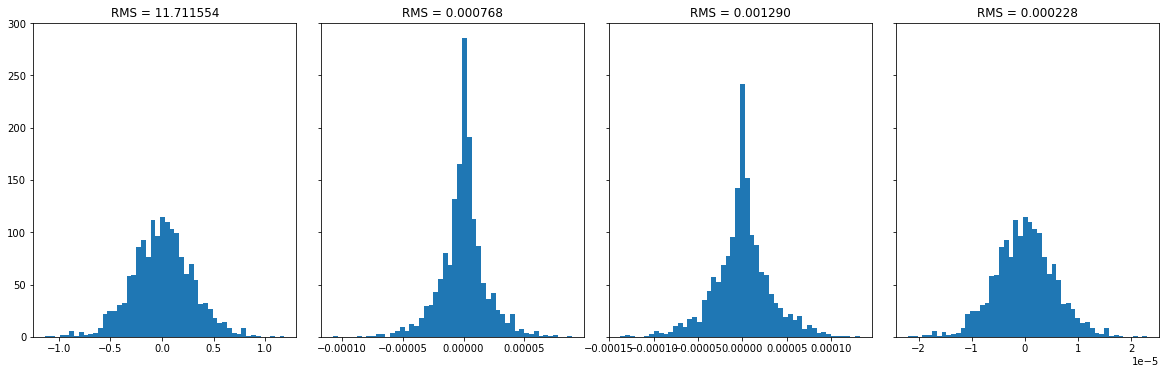

In [81]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

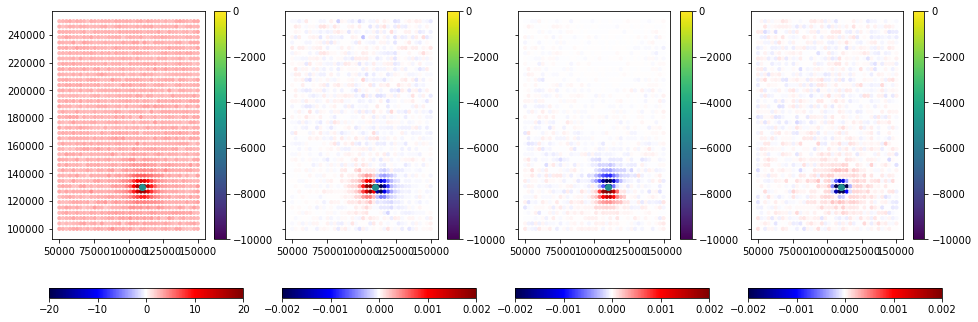

In [82]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [83]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=3, 
    step=156,
    maxit=100,
    tol=1e-3,
)

Data weights: [5.14905230e-05 5.14905230e-05 5.14905230e-05 ... 1.14440725e+04
 1.14440725e+04 1.14440725e+04]
Parameter weights: [6.66666667e-11 6.66666667e-11 6.66666667e-11 5.14905230e-05]
Initial state | Euler misfit: 54.311 | data misfit: 125.423 | step: 156
 delta p: [ 2.72508247e+03 -1.15135647e+04 -5.60341019e+03  3.16896600e+00] | Euler misfit: 64.951 | data misfit: 62.909 | step: 7.80000e+01
 delta p: [ 6.21532571e+03 -2.75364242e+04 -5.09425708e+03 -1.43484239e-02] | Euler misfit: 74.561 | data misfit: 38.561 | step: 3.90000e+01
 delta p: [ 8.80165881e+02 -4.94135859e+03  2.41528311e+03 -1.50225737e-02] | Euler misfit: 9.109 | data misfit: 17.037 | step: 1.95000e+01
 delta p: [ 1.08587233e+02 -6.01191607e+02  2.72446769e+02  2.68861294e-03] | Euler misfit: 0.085 | data misfit: 15.606 | step: 9.75000e+00
 delta p: [ 2.49592820e+01 -1.44949292e+02  5.25531422e+01  6.35919847e-04] | Euler misfit: 0.002 | data misfit: 15.553 | step: 4.87500e+00
 delta p: [ 5.07992143e+00 -2.9997

In [84]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

109959.2 130232.5 -8449.4 3.1
110000.0 130000.0 -5000.0 3.0


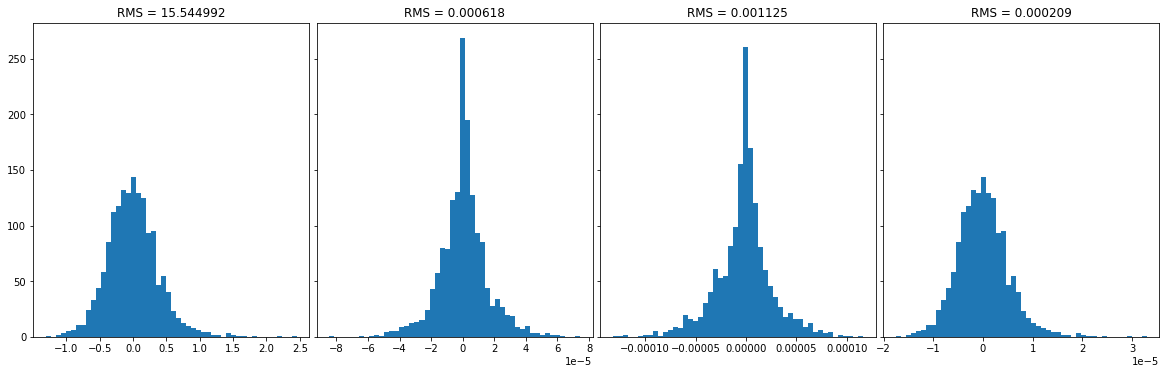

In [85]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

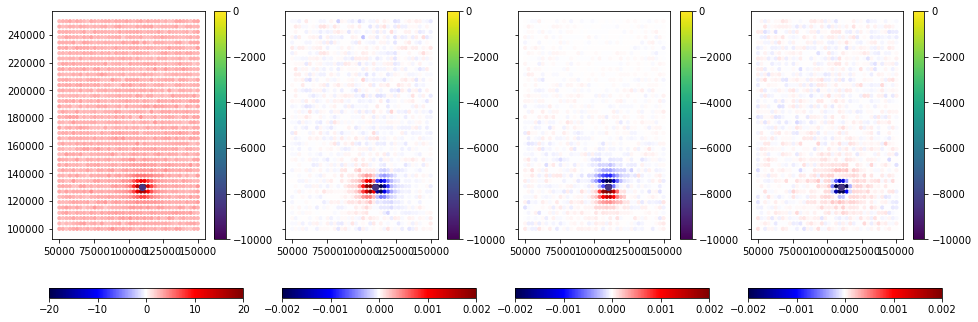

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")

In [88]:
%%time
p, h, dx, dy, dz = euler_inversion(
    coordinates, gravity, xderiv, yderiv, zderiv, 
    structural_index=1, 
    step=156,
    maxit=100,
    tol=1e-3,
)

Data weights: [5.14905230e-05 5.14905230e-05 5.14905230e-05 ... 1.14440725e+04
 1.14440725e+04 1.14440725e+04]
Parameter weights: [6.66666667e-11 6.66666667e-11 6.66666667e-11 5.14905230e-05]
Initial state | Euler misfit: 39.772 | data misfit: 125.423 | step: 156
 delta p: [ 4.62349447e+03 -1.94547971e+04 -3.66420966e+03  3.13482818e+00] | Euler misfit: 42.817 | data misfit: 34.674 | step: 7.80000e+01
Exited because of stagnation.
CPU times: user 3.63 s, sys: 0 ns, total: 3.63 s
Wall time: 3.64 s


In [89]:
print(" ".join("{:.1f}".format(i) for i in p))
print(" ".join("{:.1f}".format(i) for i in center), "{:.1f}".format(base_level))

104623.5 155545.2 -4164.2 3.1
110000.0 130000.0 -5000.0 3.0


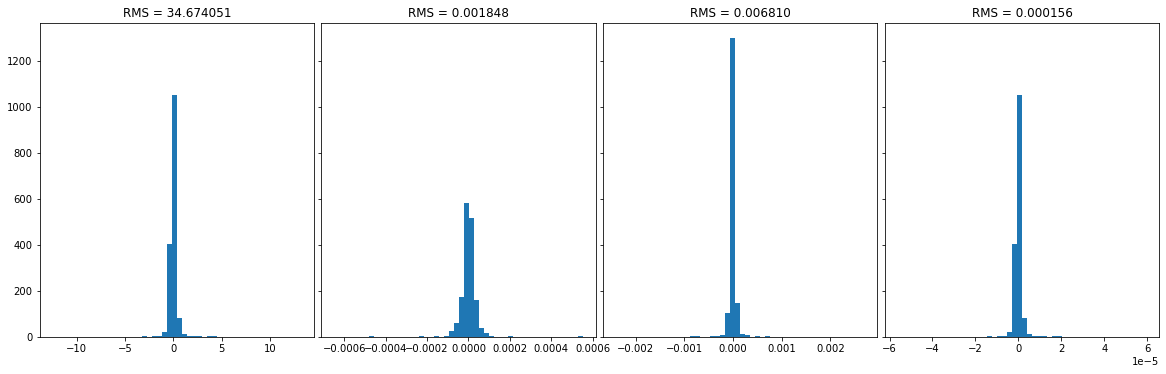

In [90]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

for ax, obs, pred in zip(axes, [gravity, xderiv, yderiv, zderiv], [h, dx, dy, dz]):
    r = obs - pred
    ax.hist(r, bins=50)
    ax.set_title("RMS = {:.6f}".format(np.linalg.norm(r)))
plt.tight_layout(pad=0)

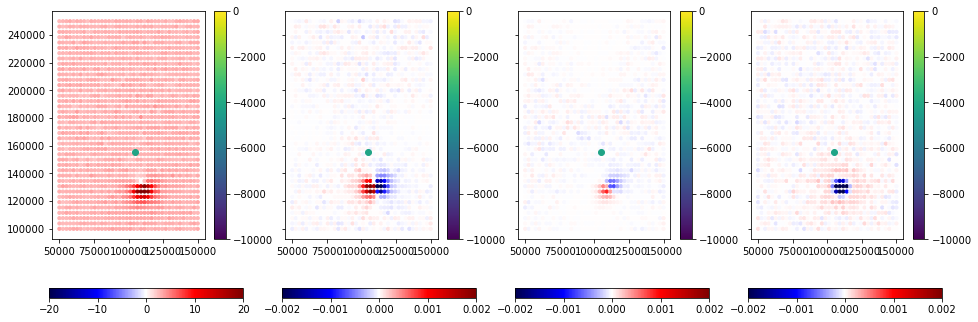

In [91]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

scale = 0.002
cmap = "seismic"
size = 10

ax = axes[0]
tmp = ax.scatter(x, y, c=h, s=size, cmap=cmap, vmin=-20, vmax=20) 
plt.colorbar(tmp, ax=ax, orientation="horizontal")

for ax, data in zip(axes[1:], [dx, dy, dz]):
    tmp = ax.scatter(x, y, c=data, s=size, cmap=cmap, vmin=-scale, vmax=scale)
    plt.colorbar(tmp, ax=ax, orientation="horizontal")
    
for ax in axes:
    tmp = ax.scatter(p[0], p[1], c=p[2], vmin=-10e3, vmax=0)
    plt.colorbar(tmp, ax=ax)  
    ax.set_aspect("equal")